# Power spectrum plots from DESI Y1 mocks

In [1]:
import os
import sys

import numpy as np
from matplotlib import pyplot as plt

sys.path.append('../bin')
from utils import load_poles, load_poles_list
from cov_utils import get_EZmocks_covariance
from desi_file_manager import DESIFileName
from local_file_manager import LocalFileName

# plotting
plt.style.use(os.path.join(os.path.abspath('../bin'), 'plot_style.mplstyle'))
plots_dir = '../../plots/'

### Global parameters

In [2]:
# tracer
tracer = 'ELG'
region = 'GCcomb'
zrange = (1.1, 1.6)

# mocks/version
version = 'v4_1'
imocks = range(25)

# multipoles
ells = (0, 2, 4)

# cut
rpcut = 0.
thetacut = 0.05

fn = DESIFileName()
fn.set_default_config(version=version, tracer=tracer, region=region, baseline=False, weighting='_default_FKP_lin', nran=18, cellsize=6, boxsize=9000)
fn.update(zrange=zrange)

## Plots

In [3]:
## EZmock covarianc
k, cov = get_EZmocks_covariance(stat='pkpoles', tracer=tracer, region=region, zrange=zrange, completeness='ffa', ells=ells, thetacut=thetacut, select=(0, 0.52, 0.005), return_x=True)

In [4]:
std = np.sqrt(np.diag(np.abs(cov))).reshape((len(ells), len(cov)//len(ells)))

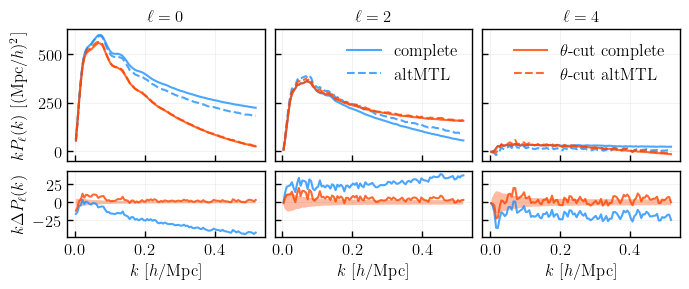

In [5]:
plt.rcParams["figure.autolayout"] = False
fig, axes = plt.subplots(2, 3, figsize=(7, 3), sharey='row', sharex=True, gridspec_kw={'height_ratios': [4, 2]})

for c, cut in zip(['C0', 'C1'], [0., max(rpcut, thetacut)]):
    fn.set_default_config(completeness=False, version=version).update(zrange=zrange)
    poles = load_poles_list([fn.get_path(realization=imock, rpcut=min(cut, rpcut), thetacut=min(cut, thetacut)) for imock in imocks], rebin=5)
    #fn.set_default_config(completeness='ffa', version='v3').update(zrange=zrange)
    #poles_ffa = load_poles_list([fn.get_path(realization=imock, rpcut=min(cut, rpcut), thetacut=min(cut, thetacut)) for imock in imocks], rebin=5)
    fn.set_default_config(completeness=True, version=version).update(zrange=zrange)
    poles_complete = load_poles_list([fn.get_path(realization=imock, rpcut=min(cut, rpcut), thetacut=min(cut, thetacut)) for imock in imocks], rebin=5)
    for i, ell in enumerate(ells):
        axes[0][i].plot(poles_complete['k'][i], poles_complete['k'][i] * poles_complete['data'][i], color=c, ls='-', alpha=0.8)
        axes[0][i].plot(poles['k'][i], poles['k'][i] * poles['data'][i], color=c, ls='--', alpha=0.8)
        axes[1][i].plot(poles['k'][i], poles['k'][i] * (poles['data'][i] - poles_complete['data'][i]), color=c, alpha=0.8)
        #axes[1][i].plot(poles['k'][i], poles['k'][i] * (poles_ffa['data'][i] - poles_complete['data'][i]), color=c, alpha=0.8, ls=':', label='ffa' if (i==0) & (c=='C0') else '')
        axes[1][i].fill_between(k, -k * std[i]/5, k * std[i]/5, facecolor='C1', alpha=0.2)
        #axes[1][i].fill_between(poles['k'][i], -poles['k'][i] * poles['std'][i]/5, poles['k'][i] * poles['std'][i]/5, facecolor='lightgrey', alpha=0.2)

axes[0][0].set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[1][0].set_ylabel(r'$k \Delta P_{\ell}(k)$')

for i, ell in enumerate(ells):
    axes[1][i].set_xlabel(r'$k$  [$h$/Mpc]')
    axes[0][i].set_title(r'$\ell={}$'.format(ell))

axes[0][1].plot([], [], ls='-', label='complete', color='C0', alpha=0.8)
axes[0][1].plot([], [], ls='--', label='altMTL', color='C0', alpha=0.8)
    
if rpcut:
    axes[0][0].plot([], [], ls='-', label='cutting $r_{{\perp}} < {} \; \mathrm{{Mpc}}/h$'.format(rpcut), color='C1', alpha=0.8)
if thetacut:
    axes[0][2].plot([], [], ls='-', label=r'$\theta$-cut complete', color='C1', alpha=0.8)
    axes[0][2].plot([], [], ls='--', label=r'$\theta$-cut altMTL', color='C1', alpha=0.8)

axes[0][1].legend()
axes[0][2].legend()
fig.align_ylabels()
plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.1)
plt.savefig(os.path.join(plots_dir, version, 'power_altmtl_{}cut{}_{}_{}_z{:.2f}-{:.2f}_{}mocks.pdf'.format('rp' if rpcut else 'theta', max(rpcut, thetacut), tracer, region, zrange[0], zrange[1], len(imocks))), dpi=200)
plt.show()

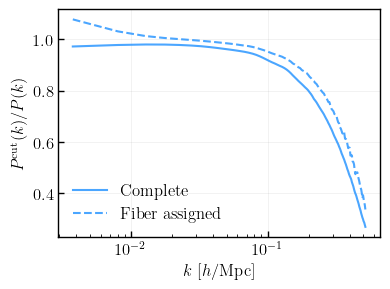

In [6]:
plt.figure(figsize=(4, 3))

# monopole only
for ls, completeness in zip(['-', '--'], [True, False]):
    fn.set_default_config(completeness=completeness, version='v3' if completeness else 'v3_1')
    poles = load_poles_list([fn.get_path(realization=imock, rpcut=0, thetacut=0) for imock in imocks], rebin=5)
    poles_cut = load_poles_list([fn.get_path(realization=imock, rpcut=rpcut, thetacut=thetacut) for imock in imocks], rebin=5)
    plt.plot(poles['k'][0], (poles_cut['data'][0]/poles['data'][0]), color='C0', ls=ls, alpha=0.8)
    # legend
    plt.plot([], [], ls=ls, label='Complete' if completeness else 'Fiber assigned', color='C0', alpha=0.8)
plt.xscale('log')

plt.ylabel(r'$P^{\mathrm{cut}}(k) / P(k)$')
plt.xlabel(r'$k$  [$h$/Mpc]')
plt.legend()
plt.show()

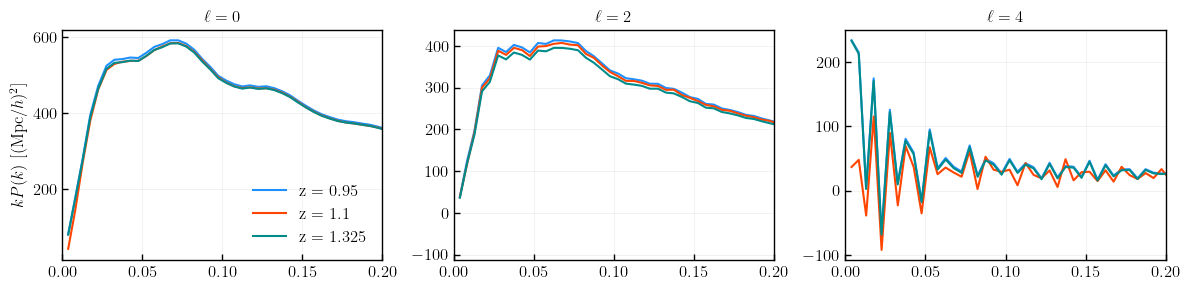

In [7]:
fn = LocalFileName()
fn.set_default_config(mockgen='cubic', tracer=tracer, z=0.95)
cubic_pk1 = load_poles_list([fn.get_path(realization=imock, los=los) for los in ('xyz') for imock in range(25)], rebin=5)

fn = LocalFileName()
fn.set_default_config(mockgen='cubic', tracer=tracer, z=1.1, cellsize=None)
cubic_pk2 = load_poles_list([fn.get_path(realization=imock, los=los) for los in ('xyz') for imock in range(25)], rebin=1)

fn = LocalFileName()
fn.set_default_config(mockgen='cubic', tracer=tracer, z=1.325, cellsize=None)
cubic_pk3 = load_poles_list([fn.get_path(realization=imock, los=los) for los in ('xyz') for imock in range(25)], rebin=5)

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=False)

for ill, ell in enumerate(ells):
    axes[ill].plot(cubic_pk1['k'][ill], cubic_pk1['k'][ill] * cubic_pk1['data'][ill], color='C0', label=r'z = 0.95')
    axes[ill].plot(cubic_pk2['k'][ill], cubic_pk2['k'][ill] * cubic_pk2['data'][ill], color='C1'.format(ill), label=r'z = 1.1')
    axes[ill].plot(cubic_pk3['k'][ill], cubic_pk3['k'][ill] * cubic_pk3['data'][ill], color='C2'.format(ill), label=r'z = 1.325')
    axes[ill].set_title(r'$\ell={}$'.format(ell))
    axes[ill].set_xlim((0, 0.2))
    
axes[0].set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[0].legend()
plt.show()

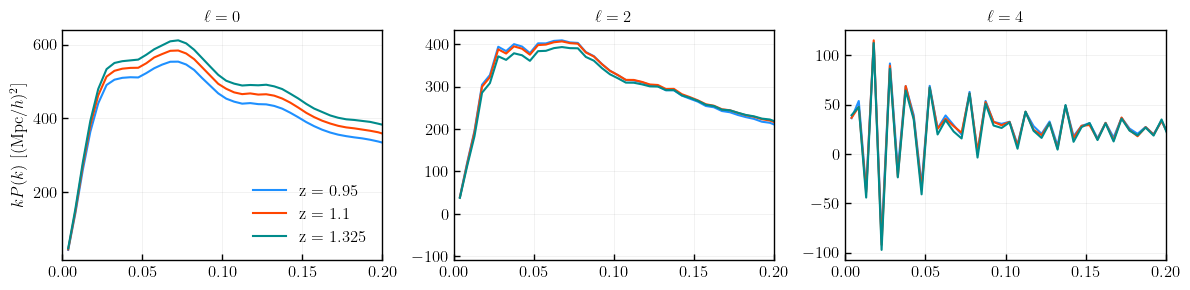

In [13]:
fn = DESIFileName()
fn.set_default_config(mocktype='SecondGenMocks/CubicBox', tracer='ELG', zrange=0.95)
cubic_pk1 = load_poles_list([fn.get_path(realization=imock, los=los) for los in ('xyz') for imock in range(25)], rebin=5)

fn = DESIFileName()
fn.set_default_config(mocktype='SecondGenMocks/CubicBox', tracer='ELG', zrange=1.1)
cubic_pk2 = load_poles_list([fn.get_path(realization=imock, los=los) for los in ('xyz') for imock in range(25)], rebin=5)

fn = DESIFileName()
fn.set_default_config(mocktype='SecondGenMocks/CubicBox', tracer='ELG', zrange=1.325)
cubic_pk3 = load_poles_list([fn.get_path(realization=imock, los=los) for los in ('xyz') for imock in range(25)], rebin=5)

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=False)

for ill, ell in enumerate(ells):
    axes[ill].plot(cubic_pk1['k'][ill], cubic_pk1['k'][ill] * cubic_pk1['data'][ill], color='C0', label=r'z = 0.95')
    axes[ill].plot(cubic_pk2['k'][ill], cubic_pk2['k'][ill] * cubic_pk2['data'][ill], color='C1'.format(ill), label=r'z = 1.1')
    axes[ill].plot(cubic_pk3['k'][ill], cubic_pk3['k'][ill] * cubic_pk3['data'][ill], color='C2'.format(ill), label=r'z = 1.325')
    axes[ill].set_title(r'$\ell={}$'.format(ell))
    axes[ill].set_xlim((0, 0.2))
    
axes[0].set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[0].legend()
plt.show()

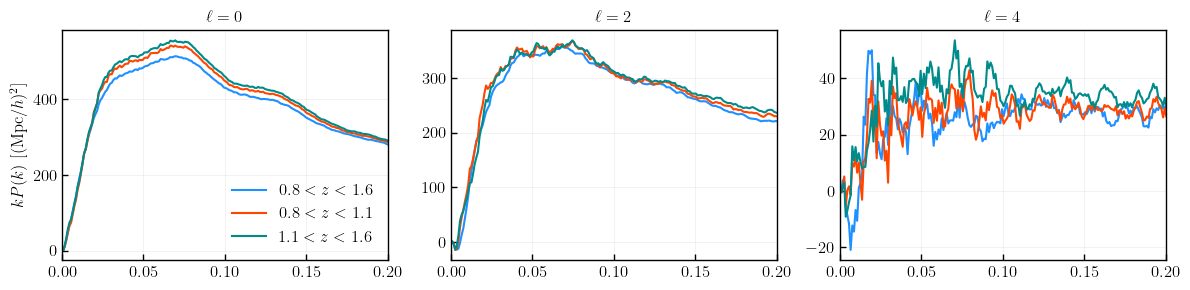

In [14]:
fn = DESIFileName()
fn.set_default_config(version='v3', tracer=tracer, region=region, completeness=True, thetacut=0.05)
    
cutsky_pk1 = load_poles_list([fn.get_path(realization=imock, zrange=(0.8, 1.1)) for imock in range(25)])
cutsky_pk2 = load_poles_list([fn.get_path(realization=imock, zrange=(0.8, 1.6)) for imock in range(25)])
cutsky_pk3 = load_poles_list([fn.get_path(realization=imock, zrange=(1.1, 1.6)) for imock in range(25)])

fn = LocalFileName()
fn.set_default_config(mockgen='second', tracer=tracer, region=region, completeness=True)
fn.update(cellsize=6)
cutsky_pk4 = load_poles_list([fn.get_path(realization=imock, zrange=(0.8, 1.6)) for imock in range(25)])

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=False)

for ill, ell in enumerate(ells):
    axes[ill].plot(cutsky_pk1['k'][ill], cutsky_pk1['k'][ill] * cutsky_pk1['data'][ill], color='C0', label=r'$0.8 < z < 1.6$')
    axes[ill].plot(cutsky_pk2['k'][ill], cutsky_pk2['k'][ill] * cutsky_pk2['data'][ill], color='C1', label=r'$0.8 < z < 1.1$')
    axes[ill].plot(cutsky_pk3['k'][ill], cutsky_pk3['k'][ill] * cutsky_pk3['data'][ill], color='C2', label=r'$1.1 < z < 1.6$')
    axes[ill].set_title(r'$\ell={}$'.format(ell))
    axes[ill].set_xlim((0, 0.2))
    
axes[0].set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[0].legend()
plt.show()

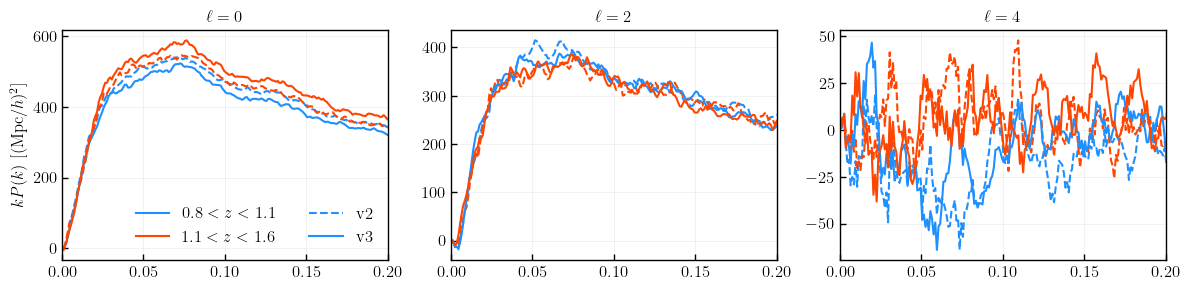

In [9]:
fn = DESIFileName()
fn.set_default_config(version='v2', tracer=tracer, region=region, completeness=False)
    
cutsky_pk1 = load_poles_list([fn.get_path(realization=imock, zrange=(0.8, 1.1)) for imock in range(25)])
cutsky_pk3 = load_poles_list([fn.get_path(realization=imock, zrange=(1.1, 1.6)) for imock in range(25)])

fn = DESIFileName()
fn.set_default_config(version='v3_1', tracer=tracer, region=region, completeness=False)
    
cutsky_pk2 = load_poles_list([fn.get_path(realization=imock, zrange=(0.8, 1.1)) for imock in range(25)])
cutsky_pk4 = load_poles_list([fn.get_path(realization=imock, zrange=(1.1, 1.6)) for imock in range(25)])

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=False)

for ill, ell in enumerate(ells):
    axes[ill].plot(cutsky_pk1['k'][ill], cutsky_pk1['k'][ill] * cutsky_pk1['data'][ill], color='C0', ls='--')
    axes[ill].plot(cutsky_pk3['k'][ill], cutsky_pk3['k'][ill] * cutsky_pk3['data'][ill], color='C1', ls='--')
    
    axes[ill].plot(cutsky_pk2['k'][ill], cutsky_pk2['k'][ill] * cutsky_pk2['data'][ill], color='C0', label=r'$0.8 < z < 1.1$')
    axes[ill].plot(cutsky_pk4['k'][ill], cutsky_pk4['k'][ill] * cutsky_pk4['data'][ill], color='C1', label=r'$1.1 < z < 1.6$')

    axes[ill].set_title(r'$\ell={}$'.format(ell))
    axes[ill].set_xlim((0, 0.2))
    
axes[0].plot([], [], ls='--', color='C0', label='v2')
axes[0].plot([], [], ls='-', color='C0', label='v3')
axes[0].set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[0].legend(ncol=2)
plt.show()